# Train a multi-layer perceptron (MLP) model 

In this notebook, we are going to use PySINGA to train a MLP model for classifying 2-d points into two categories (i.e., positive and negative). We use this example to illustrate the usage of PySINGA's modules. Please refer to the [documentation page](http://singa.apache.org/en/docs/index.html) for the functions of each module.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

To import PySINGA modules

In [2]:
from singa import tensor
from singa import optimizer
from singa import loss
from singa import layer
from singa.proto import model_pb2

Task is to train a MLP model to classify 2-d points into the positive and negative categories.

## Training data generation

The following thress steps would be conducted to generate the training data.
1. draw a boundary line in the 2-d space 
2. generate data points in the 2-dspace
3. label the data points above the boundary line as positive points, and label other points as negative points.

We draw the boundary line as $y=5x+1$

In [3]:
# generate the boundary
f = lambda x: (5 * x + 1)
bd_x = np.linspace(-1., 1, 200)
bd_y = f(bd_x)

We generate the datapoints by adding a random noise to the data points on the boundary line

In [4]:
# generate the training data
x = np.random.uniform(-1, 1, 400)
y = f(x) + 2 * np.random.randn(len(x))

We label the data points above the boundary line as positive points with label 1 and other data points with label 0 (negative).

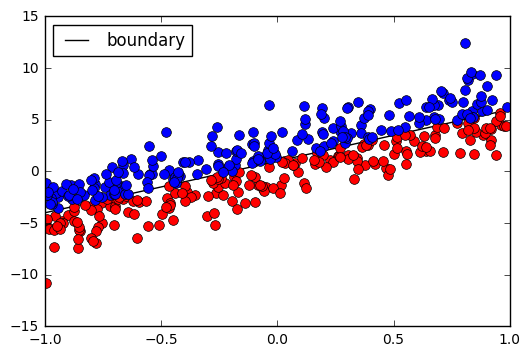

In [9]:
# convert training data to 2d space
label = np.asarray([5 * a + 1 > b for (a, b) in zip(x, y)])
data = np.array([[a,b] for (a, b) in zip(x, y)], dtype=np.float32)

plt.plot(bd_x, bd_y, 'k', label = 'boundary')
plt.plot(x[label], y[label], 'ro', ms=7)
plt.plot(x[~label], y[~label], 'bo', ms=7)
plt.legend(loc='best')
plt.show()

## Create the MLP model

1. We will create a MLP by with one dense layer (i.e. fully connected layer).
2. We use the Softmax function to get compute the probability of each category for every data point.
3. We use the cross-entropy as the loss function.
4. We initialize the weight matrix following guassian distribution (mean=0, std=0.1), and set the bias to 0.
5. We creat a SGD updater to update the model parameters.

2 and 3 are combined by the SoftmaxCrossEntropy.

In [6]:
# create layers
layer.engine = 'singacpp'
dense = layer.Dense('dense', 2, input_sample_shape=(2,))
p = dense.param_values()
print p[0].shape, p[1].shape

# init parameters
p[0].gaussian(0, 0.1) # weight matrix
p[1].set_value(0) # bias

# setup optimizer and loss func
opt = optimizer.SGD(lr=0.05)
lossfunc = loss.SoftmaxCrossEntropy()

(2, 2) (2,)


* Each layer is created with a layer name and other meta data, e.g., the dimension size for the dense layer. The last argument is the shape of a single input sample of this layer.
* **param_values()** returns a list of tensors as the parameter objects of this layer
* SGD optimzier is typically created with the weight decay, and momentum specified. The learning rate could be specified at creation or passed in when the optimizer is applied.

## Train the model

We run 1000 iterations to train the MLP model. 
1. For each iteration, we compute the gradient of the models parameters and use them to update the model parameters.
2. Periodically, we plot the prediction from the model.

training loss =  0.245654
training loss =  0.236532
training loss =  0.228489
training loss =  0.221329
training loss =  0.214903
training loss =  0.209094
training loss =  0.203810
training loss =  0.198976
training loss =  0.194531
training loss =  0.190426


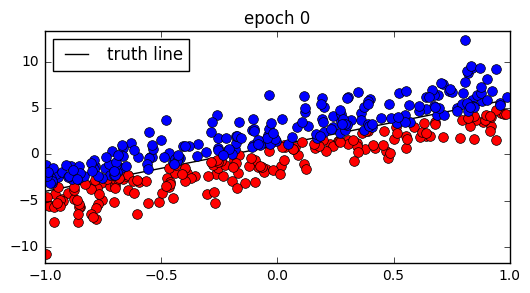

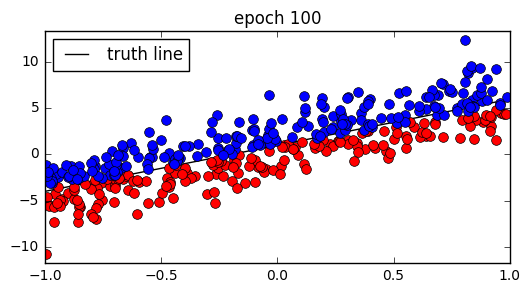

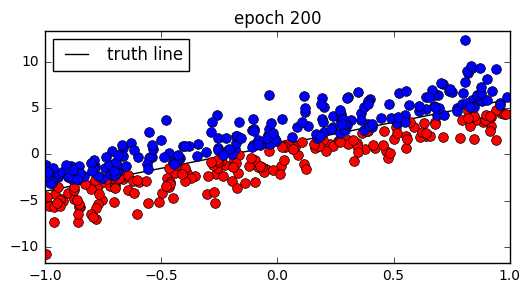

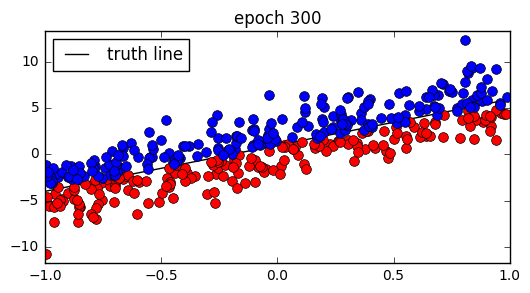

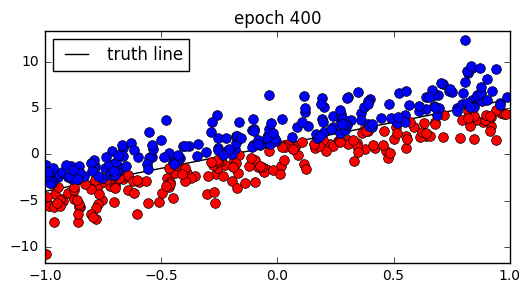

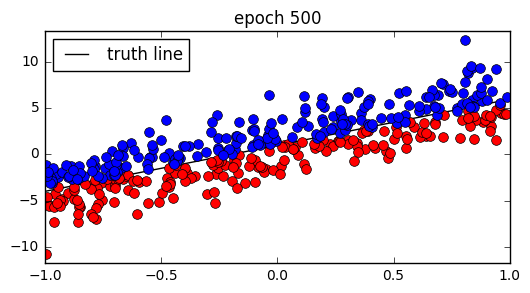

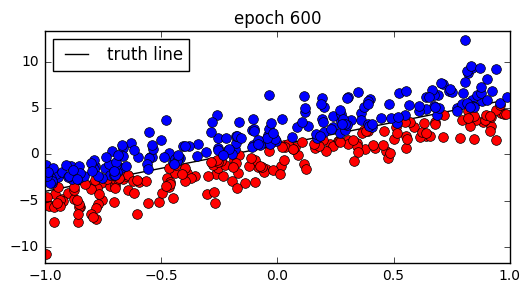

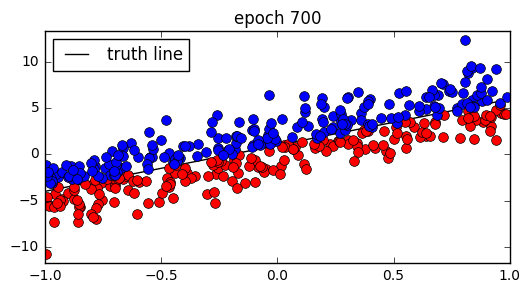

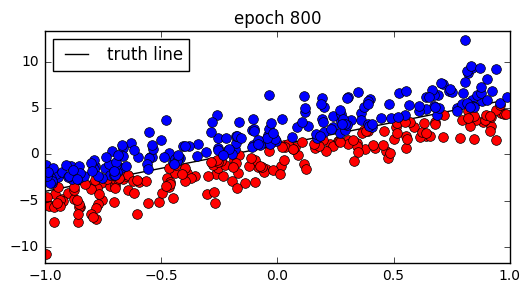

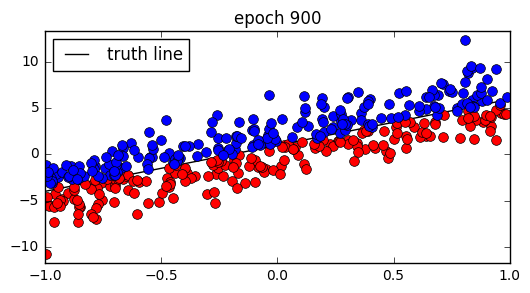

In [8]:
tr_data = tensor.from_numpy(data)
tr_label = tensor.from_numpy(label.astype(int))
# plot the classification results using the current model parameters
def plot_status(w, b, title='origin'):
    global bd_x, bd_y, data      
    pr = np.add(np.dot(data, w), b)
    lbl = pr[:, 0] < pr[:, 1]
            
    plt.figure(figsize=(6,3));
    plt.plot(bd_x, bd_y, 'k', label='truth line')    
    plt.plot(data[lbl, 0], data[lbl, 1], 'ro', ms=7)
    plt.plot(data[~lbl, 0], data[~lbl, 1], 'bo', ms=7)
    plt.legend(loc='best')
    plt.title(title)
    plt.xlim(-1, 1);
    plt.ylim(data[:, 1].min()-1, data[:, 1].max()+1)
    
# sgd
for i in range(1000):
    act = dense.forward(model_pb2.kTrain, tr_data)
    lvalue = lossfunc.forward(model_pb2.kTrain, act, tr_label)
    dact = lossfunc.backward()

    dact /= tr_data.shape[0]
    _, dp = dense.backward(model_pb2.kTrain, dact)

    # update the parameters
    opt.apply(i, dp[0], p[0], 'w')
    opt.apply(i, dp[1], p[1], 'b')

    if (i%100 == 0):
        print 'training loss =  %f' % lvalue.l1()
        plot_status(tensor.to_numpy(p[0]), tensor.to_numpy(p[1]),title='epoch %d' % i)

#train(dat, label)

The layer class has forward and backward functions for back-propagation.
* forward() accepts two arguments, the first one indicates the phase (training or evaluation); the second one includes the input tensor(s); It outputs the layer values as a single or a list of tensors.
* backward() accepts two arguments, the first one is not used currently; the second one includes the gradients of the layer values. It outputs a tuple, where the first field includes the gradient tensor(s) of the input(s), and the second field includes a list of gradients for the parameters.

The optimzier class **apply** function updates the parameter values using the gradients. The first argument is the iteration ID, followed by the gradient tensor and the value tensor. Each parameter tensor has a name associated with it, which is used by Optimizer to keep some internal data (e.g., history gradients) for each parameter.

The loss class computes the loss value given the predictions and the ground truth in **forward()** function. It computes the gradients of the predictions w.r.t the loss function and outputs the gradient tensor(s) by **backward()** function.

## Observation

We can see that prediction of the data points are getting correct labels with the training going on.